# Clustering methogs - examples

#### Michał Igła, Damian Galiniewicz, Łukasz Płonka

We choose the dataset - Cereals.xls - nutritional information, store display, and consumer ratings for 77 breakfast cereals.
Note that many records are missing some measurements. Our first goal is to estimate these missing values from “similar” records. 

##### Tasks

Fill missing data
Group data usig clustering methods


### Import potrzebnych bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans, DBSCAN, Birch, SpectralClustering, MeanShift, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances

### Funkcje pomocnicze wykorzystane w projekcie

In [2]:
def normalize(df):
    return (df - df.min()) / (df.max() - df.min())
    

In [3]:
def find_similar(sample:pd.Series, frame:pd.DataFrame, unwanted_columns=["rating", "cups", "weight", "shelf"]):
    tmp_sample = sample.dropna()
    tmp_frame = frame[tmp_sample.index]
    
    tmp_frame = tmp_frame.drop(unwanted_columns, axis=1)    
    
    tmp_frame = normalize(tmp_frame)
    
    tmp_sample = tmp_frame.loc[tmp_sample.name]
    tmp_frame = tmp_frame.drop(sample.name)
    tmp_frame = tmp_frame.dropna(axis=0)
    
    dist = pairwise_distances(tmp_sample.values.reshape(1, -1), tmp_frame, metric="euclidean")

    return frame.loc[tmp_frame.iloc[dist.argmin()].name]

In [4]:

def validate_sihoulette_score(frame, labels):
    clusters = len(set(labels))
    silhouette_avg = silhouette_score(frame, labels)
    
    print("{} clusters: {}".format(clusters, silhouette_avg))

    
    sample_silhouette_values = silhouette_samples(frame, labels)
    
    fig, ax1 = plt.subplots(1, 1)    
    y_lower = 5
    for i in range(clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
    
    
        color = cm.spectral(float(i) / clusters)

        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 5  # 5 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")  
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    return (clusters, silhouette_avg)

## Wczytanie i wstępna obróbka danych

Do pracy z danymi wykorzystana została biblioteka pandas.

W celu ułatwienia pracy z danymi tym float64 został zrzutowany na tym float(32). Umożliwia to skorzystanie z bibliotek scikit-learn.

In [5]:
df = pd.read_excel(r"Cereals.xls",
                   sheet_name="Data from DASL",
                   index_col="name")

In [6]:
for col in df.select_dtypes("float64"):
    df[col] = pd.to_numeric(df[col], downcast="float")

### Zamiana zmiennych typu "string" na zmienne binarne

Konieczna jest zamiana zmiennych reprezentujących m.in. producenta na zmienne binarne, w celu ich poprawnej interpretacji w dalszym procesie obróbki danych.

In [7]:
df["isHot"] = np.where(df.type == "H", 1, 0)
df.drop("type", axis=1, inplace=True)

In [8]:
for mfr_val in df.mfr.unique():
    df["isMfr_{}".format(mfr_val)] = np.where(df.mfr == mfr_val, 1, 0)
df.drop("mfr", axis=1, inplace=True)

### Spojrzenie na dane

Po spojrzeniu na dane możemy wstępnie określić ich poprawność, oraz czy wymagają one jeszcze jakiejś obróbki.

In [9]:
df.head()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,...,cups,rating,isHot,isMfr_N,isMfr_Q,isMfr_K,isMfr_R,isMfr_G,isMfr_P,isMfr_A
name,,,,,,,,,,,,,,,,,,,,,
100%_Bran,70,4,1,130,10.0,5.0,6.0,280.0,25,3,...,0.33,68.402969,0,1,0,0,0,0,0,0
100%_Natural_Bran,120,3,5,15,2.0,8.0,8.0,135.0,0,3,...,1.00,33.983681,0,0,1,0,0,0,0,0
All-Bran,70,4,1,260,9.0,7.0,5.0,320.0,25,3,...,0.33,59.425507,0,0,0,1,0,0,0,0
All-Bran_with_Extra_Fiber,50,4,0,140,14.0,8.0,0.0,330.0,25,3,...,0.50,93.704910,0,0,0,1,0,0,0,0
Almond_Delight,110,2,2,200,1.0,14.0,8.0,NaN,25,3,...,0.75,34.384842,0,0,0,0,1,0,0,0


### Identyfikacja brakujących danych

In [10]:
df.isna().any()

calories    False
protein     False
fat         False
sodium      False
fiber       False
carbo        True
sugars       True
potass       True
vitamins    False
shelf       False
weight      False
cups        False
rating      False
isHot       False
isMfr_N     False
isMfr_Q     False
isMfr_K     False
isMfr_R     False
isMfr_G     False
isMfr_P     False
isMfr_A     False
dtype: bool

In [11]:
df[df.isna().T.any()]

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,...,cups,rating,isHot,isMfr_N,isMfr_Q,isMfr_K,isMfr_R,isMfr_G,isMfr_P,isMfr_A
name,,,,,,,,,,,,,,,,,,,,,
Almond_Delight,110,2,2,200,1.0,14.0,8.0,NaN,25,3,...,0.75,34.384842,0,0,0,0,1,0,0,0
Cream_of_Wheat_(Quick),100,3,0,80,1.0,21.0,0.0,NaN,0,2,...,1.00,64.533813,1,1,0,0,0,0,0,0
Quaker_Oatmeal,100,5,2,0,2.7,NaN,NaN,110.0,0,1,...,0.67,50.828392,1,0,1,0,0,0,0,0


### Uzupelnienie brakujacych danych
Po zlokalizowaniu brakujących danych możemy stwierdzić, że ich liczba nie jest zbyt duża.
Pozwala nam to na wyszukiwanie produktów o podobnych cechach, każdorazowo nie biorąc pod uwagę jedynie produktów z brakującymi danymi, oraz wykluczając kolumnę z danymi, które chcemy uzupełnić.

In [12]:
for col in df[df.isna().T.any()].index:
    similar = find_similar(df.loc[col], df)
    df.loc[col] = df.loc[col].fillna(similar)

In [13]:
df[df.isna().T.any()]

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,...,cups,rating,isHot,isMfr_N,isMfr_Q,isMfr_K,isMfr_R,isMfr_G,isMfr_P,isMfr_A
name,,,,,,,,,,,,,,,,,,,,,


### Stwierdzenie poprawności wstawionych danych
Zaglądając ponownie do danych, możemy stwierdzić, że wstawione wartości wyglądają na poprawne i racjonalne.

In [14]:
df.loc[["Almond_Delight", "Cream_of_Wheat_(Quick)", "Quaker_Oatmeal"]]

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,...,cups,rating,isHot,isMfr_N,isMfr_Q,isMfr_K,isMfr_R,isMfr_G,isMfr_P,isMfr_A
name,,,,,,,,,,,,,,,,,,,,,
Almond_Delight,110.0,2.0,2.0,200.0,1.0,14.0,8.0,125.0,25.0,3.0,...,0.75,34.384842,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Cream_of_Wheat_(Quick),100.0,3.0,0.0,80.0,1.0,21.0,0.0,120.0,0.0,2.0,...,1.00,64.533813,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Quaker_Oatmeal,100.0,5.0,2.0,0.0,2.7,14.0,6.0,110.0,0.0,1.0,...,0.67,50.828392,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Wstępna obróbka danych przed grupowaniem

Dla bezpieczeństwa danych grupowanie zostało przeprowadzone na kopii. Aby nie wprowadzać sztucznych zależności dane zostały znormalizowane. 

In [15]:
df_to_cluster = normalize(df)
for column in df_to_cluster:
    if "is" in column:
        df_to_cluster[column] = df_to_cluster[column].astype("bool")
df_to_cluster.dtypes

calories    float64
protein     float64
fat         float64
sodium      float64
fiber       float32
carbo       float32
sugars      float32
potass      float32
vitamins    float64
shelf       float64
weight      float32
cups        float32
rating      float32
isHot          bool
isMfr_N        bool
isMfr_Q        bool
isMfr_K        bool
isMfr_R        bool
isMfr_G        bool
isMfr_P        bool
isMfr_A        bool
dtype: object

In [16]:
df_to_cluster.describe()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,0.517119,0.309091,0.202597,0.498985,0.153711,0.544012,0.467533,0.267574,0.282468,0.603896,0.529610,0.456831,0.325432
std,0.177128,0.218958,0.201295,0.261976,0.170240,0.215701,0.290088,0.220901,0.223425,0.416262,0.150477,0.186173,0.185658
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.454545,0.200000,0.000000,0.406250,0.071429,0.388889,0.200000,0.095238,0.250000,0.000000,0.500000,0.336000,0.199985
50%,0.545455,0.400000,0.200000,0.562500,0.142857,0.500000,0.466667,0.238095,0.250000,0.500000,0.500000,0.400000,0.295490
75%,0.545455,0.400000,0.400000,0.656250,0.214286,0.666667,0.733333,0.333333,0.250000,1.000000,0.500000,0.600000,0.433315
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Grupowanie z wykorzystaniem algorytmu KMeans

Pierwszym z algorytmów użytych do grupowania jest KMeans. W celu wybrania odpowiedniej liczby klastrów wykorzystana została metoda Sihoulette. 

2 clusters: 0.17775212071825292
3 clusters: 0.25828620077936876
4 clusters: 0.2880167895355244
5 clusters: 0.3366262606036552
6 clusters: 0.37297410469627607
7 clusters: 0.3188277375060711
8 clusters: 0.28805921060658224
9 clusters: 0.29565928805335034
Best choice: 6 clusters; score: 0.37297410469627607


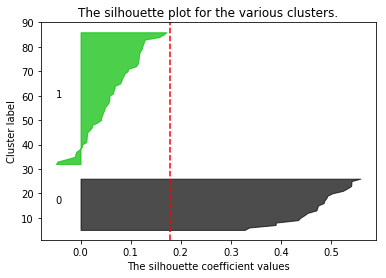

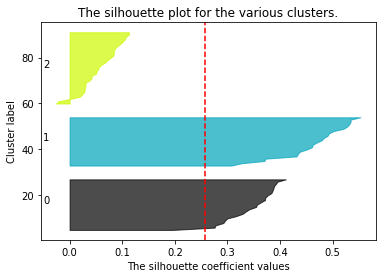

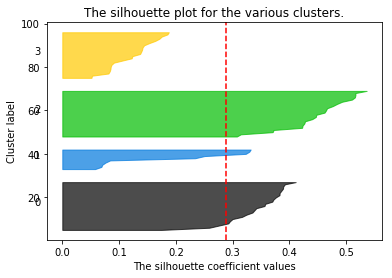

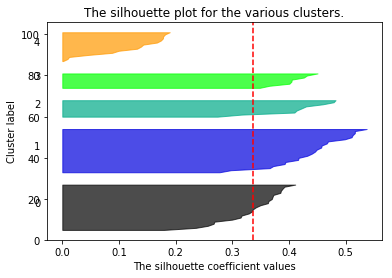

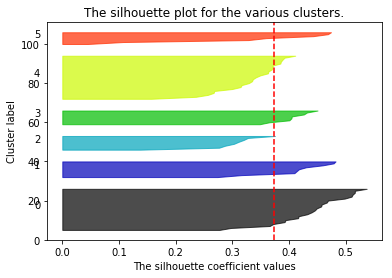

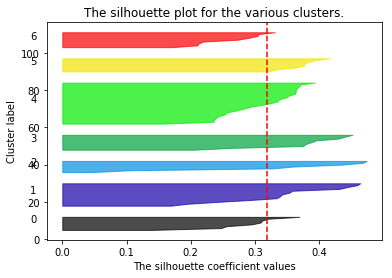

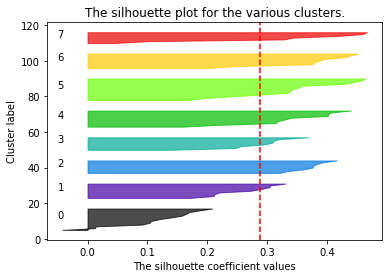

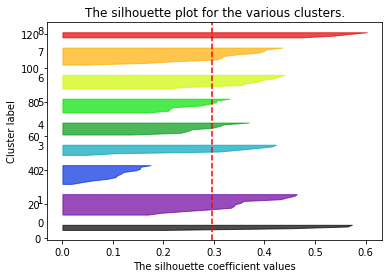

In [17]:
scores = []
for n_cls in range(2, 10):
    labels = KMeans(n_clusters=n_cls).fit_predict(df_to_cluster)
    scores.append(validate_sihoulette_score(df_to_cluster, labels))
best = max(scores, key= lambda x: x[1])
print("Best choice: {} clusters; score: {}".format(*best))

### Najlepszym wyborem wydaje sie być podział na 6 klastrow
Poniżej przedstawiona została charakterystyka grup otrzymanych w wyniku grupowania przy użyciu algorytmu KMeans.

In [18]:
best_km = KMeans(n_clusters=6).fit_predict(df)

In [19]:
df["_KMeans_group"] = best_km

In [20]:
df["_KMeans_group"].value_counts()

1    28
3    16
4    12
5    10
0     8
2     3
Name: _KMeans_group, dtype: int64

In [21]:
df.groupby("_KMeans_group").apply(lambda x: x.mean())

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,...,rating,isHot,isMfr_N,isMfr_Q,isMfr_K,isMfr_R,isMfr_G,isMfr_P,isMfr_A,_KMeans_group
_KMeans_group,,,,,,,,,,,,,,,,,,,,,
0,110.000000,1.750000,0.875000,100.625000,0.875000,11.750000,12.125000,38.750000,25.000000,2.000000,...,33.654718,0.00,0.000000,0.000000,0.500000,0.000000,0.125,0.375000,0.000000,0.0
1,108.928571,2.464286,1.142857,180.535714,1.732143,15.160714,7.142857,89.642857,35.714286,2.321429,...,39.587101,0.00,0.000000,0.071429,0.178571,0.142857,0.500,0.107143,0.000000,1.0
2,63.333333,4.000000,0.666667,176.666667,11.000000,6.666667,3.666667,310.000000,25.000000,3.000000,...,73.844462,0.00,0.333333,0.000000,0.666667,0.000000,0.000,0.000000,0.000000,2.0
3,110.625000,2.250000,0.812500,253.125000,0.593750,17.593750,5.500000,46.562500,29.687500,1.687500,...,36.660011,0.00,0.000000,0.125000,0.375000,0.125000,0.375,0.000000,0.000000,3.0
4,88.333333,2.750000,0.666667,9.166667,2.058333,15.083333,2.916667,98.333333,8.333333,2.000000,...,59.709288,0.25,0.416667,0.333333,0.166667,0.000000,0.000,0.000000,0.083333,4.0
5,128.000000,3.200000,1.600000,174.500000,4.300000,13.800000,10.900000,197.000000,32.500000,2.900000,...,38.297768,0.00,0.000000,0.000000,0.400000,0.200000,0.100,0.300000,0.000000,5.0


## Ward's method
### The minimum variance criterion

2 clusters: 0.17775212071825292
3 clusters: 0.25339838932872216
4 clusters: 0.289587588929742
5 clusters: 0.3314994301170512
6 clusters: 0.36538249477399726
7 clusters: 0.3799455231409818
8 clusters: 0.3216683494249386
9 clusters: 0.32987209910743126
Best choice: 7 clusters; score: 0.3799455231409818


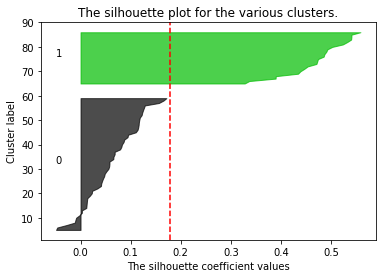

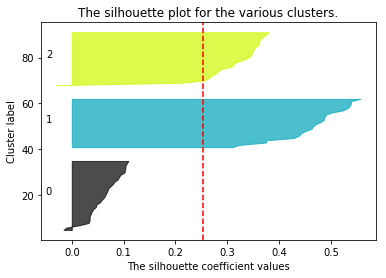

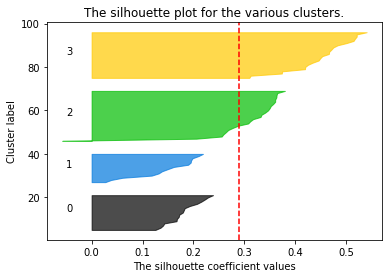

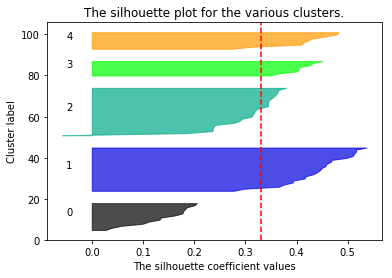

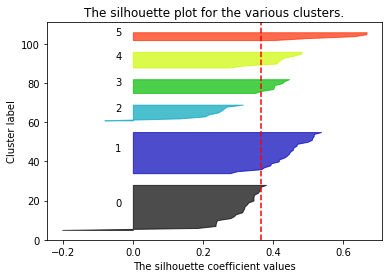

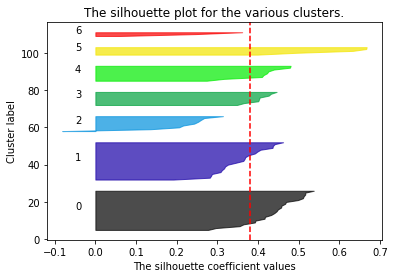

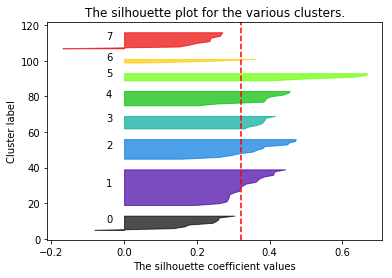

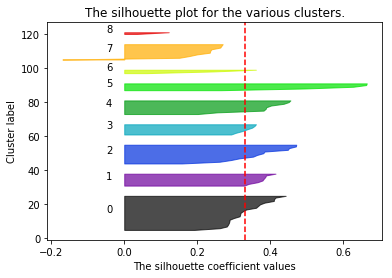

In [22]:
scores = []
for n_cls in range(2, 10):
    labels = AgglomerativeClustering(n_clusters=n_cls, linkage="ward").fit_predict(df_to_cluster)
    scores.append(validate_sihoulette_score(df_to_cluster, labels))
best = max(scores, key= lambda x: x[1])
print("Best choice: {} clusters; score: {}".format(*best))

###  Algorytm Ward'a sugeruje podział na 7 klastrów

In [23]:
best_w = AgglomerativeClustering(n_clusters=7, linkage="ward").fit_predict(df_to_cluster)
df["_Ward_group"] = best_w

In [24]:
df["_Ward_group"].value_counts()

0    22
1    21
4     9
2     9
3     8
5     5
6     3
Name: _Ward_group, dtype: int64

In [25]:
df.groupby("_Ward_group").apply(lambda x: x.mean())

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,...,isHot,isMfr_N,isMfr_Q,isMfr_K,isMfr_R,isMfr_G,isMfr_P,isMfr_A,_KMeans_group,_Ward_group
_Ward_group,,,,,,,,,,,,,,,,,,,,,
0,111.363636,2.318182,1.363636,200.454545,1.272727,14.727273,7.954545,85.227273,35.227273,2.136364,...,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.000000,1.681818,0.0
1,113.333333,2.523810,0.619048,172.380952,1.904762,15.857143,8.047619,81.904762,35.714286,2.285714,...,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,2.428571,1.0
2,95.555556,2.777778,1.666667,82.222222,1.188889,12.333333,5.777778,76.666667,13.888889,2.333333,...,0.222222,0.000000,0.888889,0.000000,0.0,0.0,0.0,0.111111,3.111111,2.0
3,115.000000,2.500000,1.250000,198.125000,1.875000,17.625000,6.125000,105.000000,25.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.000000,2.500000,3.0
4,108.888889,2.444444,0.888889,146.111111,2.777778,13.222222,8.777778,113.888889,25.000000,2.444444,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.000000,2.000000,4.0
5,90.000000,2.600000,0.000000,19.000000,2.800000,18.200000,1.000000,113.000000,5.000000,1.400000,...,0.200000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,4.000000,5.0
6,63.333333,4.000000,0.666667,176.666667,11.000000,6.666667,3.666667,310.000000,25.000000,3.000000,...,0.000000,0.333333,0.000000,0.666667,0.0,0.0,0.0,0.000000,2.000000,6.0


## DBSCAN

Algorytm DBSCAN sam znajduje odpowiednią ilość klastrów. Dla poprawnego grupowania konieczne jednak jest wybranie maksymalnej odległości między próbkami, oraz minimalnego rozmiaru klastra. Algorytm określa także niepasujące do żadnych innych klastrów próbki jako "szum" (label=-1).

Zwiększając odległość do 1.2 udało się pogrupować próbki, przy czym jedynie 4 z nich nie zostały "przypisane" do żadnej z grup.
Ostatecznie liczba klastrów wyniosła 6 + szum.

In [26]:
lbl = DBSCAN(eps=1.2, min_samples=5).fit_predict(df_to_cluster)
pd.Series(lbl).value_counts()

 0    23
 2    22
 3     9
 1     8
 4     6
 5     5
-1     4
dtype: int64

In [59]:
df["_DBSCAN_group"] = lbl

In [60]:
df.groupby("_DBSCAN_group").apply(lambda x: x.mean())

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,...,isMfr_N,isMfr_Q,isMfr_K,isMfr_R,isMfr_G,isMfr_P,isMfr_A,_KMeans_group,_Ward_group,_DBSCAN_group
_DBSCAN_group,,,,,,,,,,,,,,,,,,,,,
-1,80.000000,3.500000,1.000000,32.500000,3.175000,12.000000,3.750000,125.000000,12.500000,2.250000,...,0.25,0.5,0.0,0.0,0.0,0.0,0.25,3.500000,3.000000,-1.0
0,108.695652,2.652174,0.608696,174.782609,2.739130,15.130435,7.565217,103.043478,34.782609,2.347826,...,0.00,0.0,1.0,0.0,0.0,0.0,0.00,2.173913,1.434783,0.0
1,115.000000,2.500000,1.250000,198.125000,1.875000,17.625000,6.125000,105.000000,25.000000,2.000000,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,2.500000,3.000000,1.0
2,111.363636,2.318182,1.363636,200.454545,1.272727,14.727273,7.954545,85.227273,35.227273,2.136364,...,0.00,0.0,0.0,0.0,1.0,0.0,0.00,2.954545,0.000000,2.0
3,108.888889,2.444444,0.888889,146.111111,2.777778,13.222222,8.777778,113.888889,25.000000,2.444444,...,0.00,0.0,0.0,0.0,0.0,1.0,0.00,1.444444,4.000000,3.0
4,101.666667,2.500000,2.000000,123.333333,1.333333,11.333333,7.166667,78.333333,16.666667,2.500000,...,0.00,1.0,0.0,0.0,0.0,0.0,0.00,3.000000,2.000000,4.0
5,90.000000,2.600000,0.000000,19.000000,2.800000,18.200000,1.000000,113.000000,5.000000,1.400000,...,1.00,0.0,0.0,0.0,0.0,0.0,0.00,3.000000,5.000000,5.0
